# MÔ HÌNH HÓA DỮ LIỆU
- **VỀ DỮ LIỆU:** Dữ liệu được thu thập thêm từ thông tin chi tiết của các địa điểm của một quốc gia. Có các cột là giá trị các thông tin chi tiết đó. Và có một cột target chính là kết quả mà ta sẽ suy ra từ bộ dữ liệu input. Dữ liệu có thể được cập nhật theo ngày tháng, do đó dữ liệu sẽ gần như vô hạn. Tuy nhiên, ta chỉ dùng một ngày cố định, thường sẽ dùng today().
- VỀ MÔ HÌNH: Ta sẽ chọn 2 mô hình:
  - Mô hình gom nhóm KMeans.
  - Mô hình hồi quy tuyến tính Logitis Regression.

In [79]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Các thư viện hỗ trợ thêm
from sklearn.impute import SimpleImputer

Đọc file input dữ liệu:

- Ta có thể lấy dữ liệu gần nhất, dữ liệu today()
- Ta có thể lấy dữ liệu các ngày đã thu thập.

In [80]:
from os import walk
filenames = next(walk('./data/data'), (None, None, []))[2]  # [] if no file

# Nếu muốn train trên bộ dữ liệu là ngày hôm nay today()
# filename = filenames[-1]
# df = pd.read_csv(f'./data/data/{filename}')

# Nếu muốn test trên bộ dữ liệu là các ngày mà ta thu thập...
cnt = 0
for filename in filenames:    
    if cnt == 0:
        df = pd.read_csv(f'./data/data/{filename}')
    else:
        df = pd.concat([df, pd.read_csv(f'./data/data/{filename}')])
    cnt += 1
df.head()

,Thời tiết,Nhiệt độ,Độ ẩm,Gió,Áp suất,PM2.5,PM10,O3,NO2,SO2,target,CO
0,Trời quang,18°C,29%,10.1 km/h,1014 mbar,62.8,279,3,100,28.8,Không lành mạnh,NaN
1,Trời quang,19°C,23%,11.2 km/h,1013 mbar,75.1,277,10,79.2,9.6,Không lành mạnh,1720.0
2,Nhiều mây,-1°C,45%,7 km/h,1032 mbar,109,477.5,56.5,31,8.5,Nguy hiểm,450.0
3,Sương mù,19°C,45%,5.5 km/h,1014 mbar,87,NaN,NaN,NaN,NaN,Không lành mạnh,NaN
4,Trời quang,21°C,32%,10.6 km/h,1012 mbar,52.2*,NaN,NaN,NaN,NaN,Không lành mạnh cho các nhóm nhạy cảm,NaN


In [81]:
df['target'].value_counts()

Tốt                                      584
Trung bình                               205
Không lành mạnh                          101
Không lành mạnh cho các nhóm nhạy cảm     78
Nguy hiểm                                 17
Rất không lành mạnh                       14
Name: target, dtype: int64

Quy các kiểu dữ liệu `string` về thành `int` để có thể tính mean

In [82]:
weather = ['Nhiều mây', 'Trời quang', 'Mưa', 'Mây rải rác', 'Sương mù', 'Ít mây', 'Tuyết', 'Mưa rào', 'Giông bão']
target = ['Tốt', 'Trung bình', 'Không lành mạnh', 'Không lành mạnh cho các nhóm nhạy cảm', 
          'Rất không lành mạnh', 'Nguy hiểm']
df = df.replace(weather, np.arange(len(weather)))
df = df.replace(target, np.arange(len(target)))
df.head()

,Thời tiết,Nhiệt độ,Độ ẩm,Gió,Áp suất,PM2.5,PM10,O3,NO2,SO2,target,CO
0,1,18°C,29%,10.1 km/h,1014 mbar,62.8,279,3,100,28.8,2,NaN
1,1,19°C,23%,11.2 km/h,1013 mbar,75.1,277,10,79.2,9.6,2,1720.0
2,0,-1°C,45%,7 km/h,1032 mbar,109,477.5,56.5,31,8.5,5,450.0
3,4,19°C,45%,5.5 km/h,1014 mbar,87,NaN,NaN,NaN,NaN,2,NaN
4,1,21°C,32%,10.6 km/h,1012 mbar,52.2*,NaN,NaN,NaN,NaN,3,NaN


Format lại các thông tin trong dữ liệu

In [83]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df['Nhiệt độ'] = df['Nhiệt độ'].str.replace('°C', '')
    df['Độ ẩm'] = df['Độ ẩm'].str.replace('%', '')
    df['Gió'] = df['Gió'].str.replace(' km/h', '')
    df['Áp suất'] = df['Áp suất'].str.replace(' mbar', '')
    df[' PM2.5 '] = df[' PM2.5 '].str.replace('*', '')
    df[' PM10 '] = df[' PM10 '].str.replace('*', '')
    df[' O3 '] = df[' O3 '].str.replace('*', '')
    df[' NO2 '] = df[' NO2 '].str.replace('*', '')
    df[' SO2 '] = df[' SO2 '].str.replace('*', '')

In [84]:
df = df.astype(np.float64)
df.head()

,Thời tiết,Nhiệt độ,Độ ẩm,Gió,Áp suất,PM2.5,PM10,O3,NO2,SO2,target,CO
0,1.0,18.0,29.0,10.1,1014.0,62.8,279.0,3.0,100.0,28.8,2.0,NaN
1,1.0,19.0,23.0,11.2,1013.0,75.1,277.0,10.0,79.2,9.6,2.0,1720.0
2,0.0,-1.0,45.0,7.0,1032.0,109.0,477.5,56.5,31.0,8.5,5.0,450.0
3,4.0,19.0,45.0,5.5,1014.0,87.0,NaN,NaN,NaN,NaN,2.0,NaN
4,1.0,21.0,32.0,10.6,1012.0,52.2,NaN,NaN,NaN,NaN,3.0,NaN


Như đã thấy thì dữ liệu của mô hình có các giá trị NaN. Ta không thể drop các giá trị đó hoặc thay bằng 0, có nhiều cách để thay thế giá trị NaN, tuy nhiên ở đây chúng ta sẽ thay các giá trị NaN bằng mean.

In [85]:
X = df.iloc[:, :-1]
Y = df['target']

imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')
imputer = imputer.fit(X)
X = imputer.transform(X)

## MÔ HÌNH 1: **KMEANS**
- X sẽ là các cột dữ liệu thông tin về thời tiết và không khí.
- Y sẽ là các kết quả thực tế đo được.

In [86]:
# Models Kmeans
from sklearn.cluster import KMeans
from sklearn import datasets
from scipy.spatial.distance import cdist

### Dùng **Kmeans** để gom nhóm các giá trị input và dự đoán xem sẽ có bao nhiêu nhóm dựa vào **Elbow method**.

In [87]:
y_kmeans = []
ineria = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(2, 10):
        kmeans = KMeans(n_clusters = i, random_state = 0).fit(X)
        y_kmeans.append(kmeans.labels_)
        ineria.append(kmeans.inertia_)

Việc kiểm tra bằng mắt đôi khi không khả thi (giả sử khi số lượng mẫu thử và sai quá lớn). Do đó, cần một độ đo để kiểm tra chất lượng gom cụm. Tiếp theo, các bạn sẽ tìm hiểu và trình bày ngắn gọn về **Elbow method**. Sau đó, bạn sẽ trực quan hóa kết quả sử dụng **Elbow method** để chọn được số cụm thích hợp.

Tìm hiểu và trình bày về **Elbow method**
- Trong phương pháp gom nhóm, thì Elbow method là một heuristic được xác định số lượng cụm trong một tập dữ liệu.
- Phương pháp bao gồm vẽ đồ thị biến thể được giải thích dưới dạng một hàm của số lượng cụm và chọn các khớp của đường cong là số lượng trục.
- Điểm khuỷ tay là điểm mà ở đó tốc độ suy giảm của hàm biến dạng sẽ thay đổi nhiều nhất. Tức là kể từ sau vị trí này thì gia tăng thêm số lượng cụm cũng không giúp hàm biến dạng giảm đáng kể. Nếu thuật toán phân chia theo số lượng cụm tại vị trí này sẽ đạt được tính chất phân cụm một cách tổng quát nhất mà không gặp các hiện tượng vị khớp (overfitting)

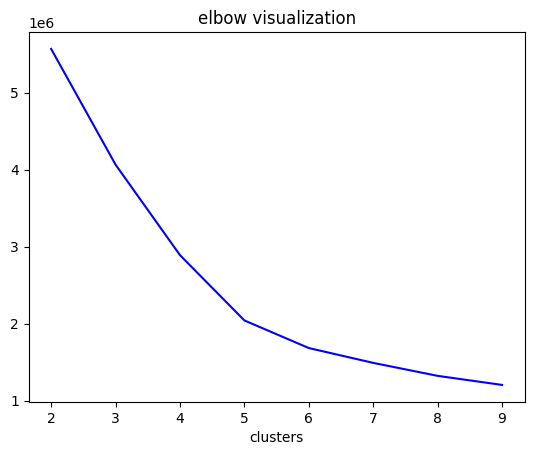

In [88]:
plt.plot(np.arange(2, 10), ineria, 'b-')
plt.xlabel('clusters')
plt.title('elbow visualization')
plt.show()

**Kết luận:** Số cụm phù hợp là 4 hoặc 5 *(tùy dữ liệu)*

**ĐÁNH GIÁ MÔ HÌNH**

## MÔ HÌNH 2: **LOGITIS REGRESSION**
- X sẽ là các cột dữ liệu thông tin về thời tiết và không khí.
- Y sẽ là các kết quả thực tế đo được.

In [89]:
# Models Logitis Regression
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Từ dữ liệu ta sẽ tạo ra tập train và tập test

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3)

Sau đó fix dữ liệu train với model

In [91]:
mymodel = linear_model.LogisticRegression(max_iter = 120)
mymodel.fit(X_train,y_train)

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=120)

 Độ so khớp của mô hình với dữ liệu (%)

In [92]:
mymodel.score(X_test, y_test)

0.89

Tập dự đoán 

In [93]:
predicted_output = mymodel.predict(X_test)
predicted_output

array([3., 1., 2., 2., 0., 0., 1., 0., 0., 0., 0., 2., 0., 0., 2., 1., 0.,
       1., 0., 0., 1., 2., 0., 1., 3., 0., 2., 1., 2., 0., 0., 1., 0., 1.,
       0., 0., 3., 0., 0., 1., 0., 0., 1., 2., 1., 3., 1., 0., 0., 1., 3.,
       0., 1., 1., 2., 0., 1., 1., 1., 0., 0., 0., 2., 0., 0., 1., 1., 1.,
       0., 1., 1., 0., 0., 0., 3., 0., 0., 0., 3., 0., 1., 0., 0., 0., 0.,
       0., 2., 0., 0., 1., 0., 3., 0., 1., 0., 2., 0., 1., 0., 0., 2., 0.,
       0., 0., 1., 5., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       2., 3., 0., 0., 2., 1., 2., 0., 0., 0., 0., 0., 3., 0., 0., 1., 0.,
       0., 0., 1., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 2., 0., 2., 0., 0., 0., 2., 0., 0., 0., 2., 2., 5., 0., 0.,
       0., 2., 3., 0., 5., 1., 0., 1., 2., 0., 3., 0., 1., 0., 2., 0., 0.,
       2., 1., 1., 2., 0., 0., 0., 1., 0., 0., 0., 0., 0., 3., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 2., 3., 0., 1., 0., 0., 1., 0., 2.,
       2., 3., 2., 0., 2.

**ĐÁNH GIÁ MÔ HÌNH**

In [94]:
test = confusion_matrix(y_test, predicted_output)
test

array([[170,   1,   0,   0,   0,   0],
       [ 19,  45,   0,   2,   0,   0],
       [  0,   0,  30,   1,   1,   0],
       [  0,   3,   1,  18,   0,   0],
       [  0,   0,   3,   0,   0,   1],
       [  0,   0,   1,   0,   0,   4]], dtype=int64)

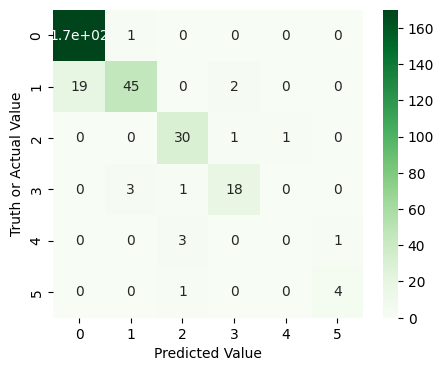

In [95]:
plt.figure(figsize = (5,4))
sns.heatmap(test, annot = True, cmap = 'Greens')
plt.xlabel('Predicted Value')
plt.ylabel('Truth or Actual Value')
plt.show()

**NHẬN XÉT**

# SO SÁNH 2 MÔ HÌNH